In [1]:
%matplotlib inline

import numpy as np
import torch
from torch import Tensor
from torch.autograd import Variable
import torch.optim as opt
import tensorflow as tf
import gym

import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v0')

INFO:gym.envs.registration:Making new env: CartPole-v0
[2017-07-29 03:00:44,354] Making new env: CartPole-v0


In [3]:
gamma = 0.99
lr = 0.05
hidden = 8
num_action = env.action_space.n
num_state = env.observation_space.shape[0]

In [4]:
def discount_rewards(r):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [5]:
tf.reset_default_graph()

x = tf.placeholder(dtype=tf.float32,shape=[None,num_state])
w1 = tf.Variable(np.random.randn(num_state,hidden),name='w1',dtype=tf.float32)
b1 = tf.Variable(np.random.randn(1,hidden),name='b1',dtype=tf.float32)
layer1 = tf.nn.relu(tf.matmul(x,w1) + b1)
w2 = tf.Variable(np.random.randn(hidden,num_action),name='w2',dtype=tf.float32)
b2 = tf.Variable(np.random.randn(1,num_action),name='b2',dtype=tf.float32)
layer2 = tf.nn.sigmoid(tf.matmul(layer1,w2) + b2)
output = tf.nn.softmax(layer2)

chosen_action = tf.argmax(output,axis=1)

action_holder = tf.placeholder(tf.float32,[None,num_action])
reward_holder = tf.placeholder(tf.float32,[None])

cost = -tf.reduce_mean(tf.log(tf.reduce_sum(output * action_holder,axis=1)) * 
                      reward_holder)

gradient_holders = []
tvars = tf.trainable_variables()
for idx,var in enumerate(tvars):
    ph = tf.placeholder(tf.float32,name=str(idx)+'_holder')
    gradient_holders.append(ph)
    
grad = tf.gradients(cost,tvars)
opt = tf.train.AdamOptimizer(lr)
update = opt.apply_gradients(zip(gradient_holders,tvars))

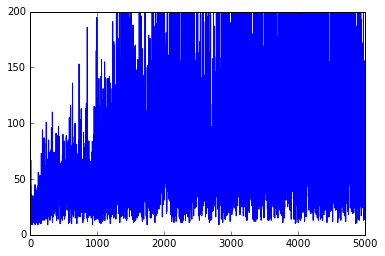

In [7]:
epoch = 5000
init = tf.global_variables_initializer()
amap = np.identity(num_action)

with tf.Session() as sess:
    sess.run(init)
    
    total_rewards = []
    
    gradient_buffer = sess.run(tf.trainable_variables())
    for ix,gd in enumerate(gradient_buffer):
        gradient_buffer[ix] = gd * 0
    
    for i in range(epoch):
        s = env.reset()
        done = False
        total_reward = 0
        s_hist = []
        a_hist = []
        r_hist = []
        while not done:
            
            a_dist = sess.run(output,feed_dict={x:[s]})
            a = np.random.choice(a_dist[0],p=a_dist[0])
            a = np.argmax(a_dist == a)
            
            s1,r,done,_ = env.step(a)
            s_hist.append(s)
            a_hist.append(amap[a:a+1][0])
            r_hist.append(r)
            total_reward += r
            if done:
                s_h = np.array(s_hist,dtype=np.float32)
                a_h = np.array(a_hist,dtype=np.float32)
                r_h = discount_rewards(np.array(r_hist,dtype=np.float32))
                c,g = sess.run([cost,grad],{x:s_h,action_holder:a_h,reward_holder:r_h})

                for ix,gd in enumerate(g):
                    gradient_buffer[ix] += gd
                    
                if i % 10 == 0 and i != 0:
                    sess.run(update,feed_dict=dict(zip(gradient_holders, gradient_buffer)))
                    for ix,gd in enumerate(g):
                        gradient_buffer[ix] = 0
#                     print total_reward
                    
                total_rewards.append(total_reward)
            s = s1
    plt.plot(total_rewards)